In [1]:
from huggingface_hub import notebook_login
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics  # Additional scklearn functions
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    make_scorer,
    roc_auc_score,
    f1_score,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)

from pytorch_earlystopping import EarlyStopping

from vit_flash import ViTFlashAttn
from vit_flash_spectformer_real import ViTFlashAttnSpect
from vit_flash_spectformer_neo import ViTFlashAttnNeoSpect
from vit_flash_spectral_attention import ViTFlashAttnSpectralAttn

EPOCHS = 500
PATIENCE = 25
BATCH_SIZE = 1024
torch.manual_seed(39)
CURR_VER = "v1"
EPOCH_LEN = len(str(EPOCHS))

In [2]:
# notebook_login()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

device = torch.device(device)

Using cuda device


In [4]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data_dict = {
    "data": [],
    "labels": [],
    "filenames": []
}

file_name = "cifar-10-batches-py"
for file_num in range(5):
    loaded_data_dict = unpickle(f"{file_name}/data_batch_{file_num+1}")
    train_data_dict["data"].extend(loaded_data_dict[b'data'])
    train_data_dict["labels"].extend(loaded_data_dict[b'labels'])
    train_data_dict["filenames"].extend(loaded_data_dict[b'filenames'])

train_data_dict

{'data': [array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8),
  array([154, 126, 105, ..., 139, 142, 144], dtype=uint8),
  array([255, 253, 253, ...,  83,  83,  84], dtype=uint8),
  array([28, 37, 38, ..., 28, 37, 46], dtype=uint8),
  array([170, 168, 177, ...,  82,  78,  80], dtype=uint8),
  array([159, 150, 153, ...,  14,  17,  19], dtype=uint8),
  array([164, 105, 118, ...,  29,  26,  44], dtype=uint8),
  array([ 28,  30,  33, ..., 100,  99,  96], dtype=uint8),
  array([134, 131, 128, ..., 136, 137, 138], dtype=uint8),
  array([125, 110, 102, ...,  82,  84,  86], dtype=uint8),
  array([53, 54, 56, ..., 39, 46, 41], dtype=uint8),
  array([142, 172, 176, ..., 105, 106, 111], dtype=uint8),
  array([164, 162, 162, ..., 108, 107, 100], dtype=uint8),
  array([17, 17, 17, ..., 20, 18, 16], dtype=uint8),
  array([100,  98,  99, ..., 139, 141, 137], dtype=uint8),
  array([100, 100, 101, ..., 167, 183, 202], dtype=uint8),
  array([235, 235, 237, ...,  27,  23,  14], dtype=uint8),
  array

In [6]:
len(train_data_dict["labels"])

50000

In [7]:
train_data_dict["data"][0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [8]:
image_array = np.reshape(train_data_dict["data"][0], (3, 32, 32))
image_array

array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ...,
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ...,
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ...,
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)

In [9]:
image_array = np.transpose(image_array, (1, 2, 0))
image_array

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

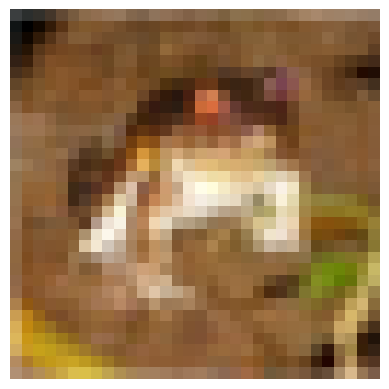

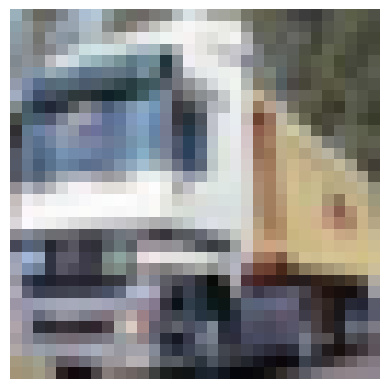

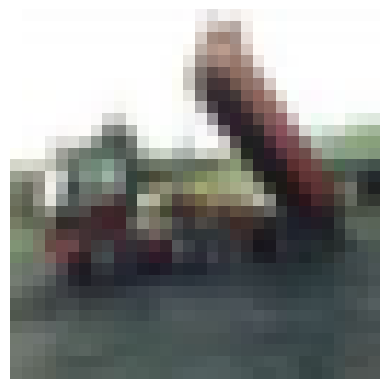

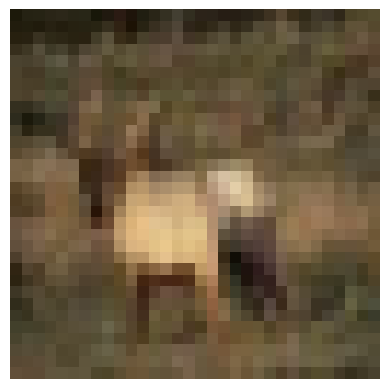

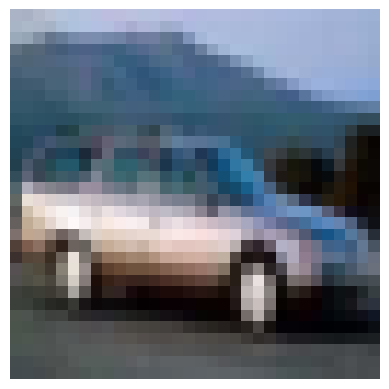

In [10]:
for img_num in range(5):
    image_array = np.reshape(train_data_dict["data"][img_num], (3, 32, 32))

    image_array = np.transpose(image_array, (1, 2, 0))

    # Display the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

In [11]:
train_data_dict["img"] = np.reshape(train_data_dict["data"], (50_000, 3, 32, 32))

In [12]:
train_data_dict["img"][0]

array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ...,
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ...,
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ...,
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)

In [13]:
test_data_dict = {
    "data": [],
    "labels": [],
    "filenames": []
}
loaded_data_dict = unpickle(f"{file_name}/test_batch")
test_data_dict["data"].extend(loaded_data_dict[b'data'])
test_data_dict["labels"].extend(loaded_data_dict[b'labels'])
test_data_dict["filenames"].extend(loaded_data_dict[b'filenames'])

test_data_dict["img"] = np.reshape(test_data_dict["data"], (10_000, 3, 32, 32))
len(test_data_dict["labels"])

10000

In [14]:
X = train_data_dict["img"]
y = np.array(train_data_dict["labels"])

X_test = test_data_dict["img"]
y_test = np.array(test_data_dict["labels"])

In [15]:
## train data
class trainData(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        
        if self.transform is not None:
            x = self.transform(x)
            
        return x, y

    def __len__(self):
        return len(self.x_data)

## val data
class valData(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        
        if self.transform is not None:
            x = self.transform(x)
            
        return x, y

    def __len__(self):
        return len(self.x_data)


## test data
class testData(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        
        if self.transform is not None:
            x = self.transform(x)
            
        return x, y

    def __len__(self):
        return len(self.x_data)

In [16]:
def get_splitted_data(train_index,val_index):
    
    print(len(train_index))
    print(len(val_index))

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_data = trainData(
        torch.FloatTensor(X_train).to(device),
        torch.FloatTensor(y_train).to(device),
        transform = train_transform
    )

    test_data = testData(
        torch.FloatTensor(X_test).to(device),
        torch.FloatTensor(y_test).to(device),
        transform = transform
    )

    val_data = valData(
        torch.FloatTensor(X_val).to(device),
        torch.FloatTensor(y_val).to(device),
        transform = transform
    )

    return train_data, test_data, val_data, y_test, y_val

In [17]:
all_models_list = [
    ViTFlashAttn,
    ViTFlashAttnSpect,
    ViTFlashAttnSpect,
    ViTFlashAttnNeoSpect,
    ViTFlashAttnSpectralAttn,
]

all_models_name = [
    "ViTFlash",
    "ViTSpect",
    "GFNet",
    "ViTSpectNeo",
    "ViTSpectAttn",
]

contain_spect = {
    "ViTSpect":{
        "spect_alpha":4,
    },
    "GFNet":{
        "spect_alpha":12,
    }
}

dropouts_dicts = {
    "ViTFlash":{
        "att_dropout":0.05,
        "drop_path":0.,
        "ff_dropout":0.,
    },
    "ViTSpect":{
        "att_dropout":0.05,
        "drop_path":0.,
        "ff_dropout":0.,
    },
    "GFNet":{
        "att_dropout":0.05,
        "drop_path":0.,
        "ff_dropout":0.,
    },
    "ViTSpectNeo":{
        "att_dropout":0.05,
        "drop_path":0.,
        "ff_dropout":0.,
    },
    "ViTSpectAttn":{
        "att_dropout":0.05,
        "drop_path":0.,
        "ff_dropout":0.,
    },
}


In [18]:
def one_hot_ce_loss(criterion, outputs, targets):
    targets = targets.to(device, dtype=torch.uint8)
    
    return criterion(outputs, targets)

In [19]:
@torch.no_grad()
def validation_score(model, val_loader, val_labels):
    model.eval()
    for val_x_data, val_y_data in val_loader:
        with torch.no_grad():
            y_val_pred = model(val_x_data)
            val_loss = one_hot_ce_loss(criterion, y_val_pred, val_y_data)
            
    return val_loss

In [20]:
def model_training(
    model,
    epochs,
    train_loader,
    test_loader,
    test_labels,
    criterion,
    optimizer,
    lr_scheduler,
    vit_model_name,
    versioning,
):

    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    early_stopping = EarlyStopping(
        patience=PATIENCE,
        verbose=True,
        path=f"model_weight/saved_model{CURR_VER}_{vit_model_name}{versioning}.pth",
    )

    min_valid_loss = np.inf
    start_time = time.time()

    for e in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        epoch_f1_score = 0
        for train_x_data, train_y_data in train_loader:

            optimizer.zero_grad()
            y_pred = model(train_x_data)

            loss = one_hot_ce_loss(criterion, y_pred, train_y_data)

            _, y_pred_max = torch.max(y_pred, dim=1)

            f1_score_val = f1_score(train_y_data.unsqueeze(1).cpu(), y_pred_max.cpu(), average="macro")

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            epoch_f1_score += f1_score_val.item()
        lr_scheduler.step()

        model.eval()
        epoch_val_loss = 0
        epoch_val_f1 = 0
        for val_x_data, val_y_data in val_loader:

            with torch.no_grad():
                y_val_pred = model(val_x_data)

                val_loss = one_hot_ce_loss(criterion, y_val_pred, val_y_data)

                _, y_val_pred_max = torch.max(y_val_pred, dim=1)

                f1_score_val = f1_score(val_y_data.unsqueeze(1).cpu(), y_val_pred_max.cpu(), average="macro",)

                epoch_val_loss += val_loss.item()
                epoch_val_f1 += f1_score_val.item()

        avg_loss_train = epoch_loss / len(train_loader)
        avg_f1_train = epoch_f1_score / len(train_loader)
        avg_loss_val = epoch_val_loss / len(val_loader)
        avg_f1_val = epoch_val_f1 / len(val_loader)

        avg_train_losses.append(avg_loss_train)
        avg_valid_losses.append(avg_loss_val)

        time_taken = time.time() - start_time
        time_format = time.strftime("%H:%M:%S", time.gmtime(time_taken))

        print(
            f"[{e:>{EPOCH_LEN}}/{epochs:>{EPOCH_LEN}}] Loss: {avg_loss_train:.5f} | "
            + f"F1-score: {avg_f1_train:.3f} | Val Loss: {avg_loss_val:.3f} | "
            + f"Val F1: {avg_f1_val:.3f} | {time_format}s"
        )

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_loss_val, model)

        if early_stopping.early_stop:
            print(f"Early stopping after {e+0:03} Epochs")
            break

    train_losses_list.append(avg_train_losses)
    valid_losses_list.append(avg_valid_losses)

    return model, time_taken, min_valid_loss

In [21]:
def evaluate_model(model, test_loader, test_labels, vit_model_name, versioning):
    print(f"... loading model's best weight of {vit_model_name}{versioning}")
    model.load_state_dict(
        torch.load(
            f"model_weight/saved_model{CURR_VER}_{vit_model_name}{versioning}.pth"
        )
    )

    model.to(device)
    y_pred_list = []
    y_pred_list_rocauc = []
    model.eval()
    with torch.no_grad():
        for test_x_data, _ in test_loader:

            y_test_pred = model(test_x_data)

            y_test_pred_rocauc = F.softmax(y_test_pred, dim=1)
            y_pred_list_rocauc.append(y_test_pred_rocauc.cpu().numpy()[0])

            y_test_pred = torch.max(y_test_pred, dim=1)[1]
            y_pred_list.append(y_test_pred.cpu().numpy())

    y_pred_list = [pred.astype(int).squeeze().tolist() for pred in y_pred_list]
    print(len(y_pred_list))

    conf_matrix = confusion_matrix(test_labels, y_pred_list)
    print(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4,5,6,7,8,9])
    disp.plot(values_format='')
    plt.show()
    print(classification_report(test_labels, y_pred_list))

    clf_rep_dict = classification_report(test_labels, y_pred_list, output_dict=True)
    clf_rep_dict["roc_auc"] = roc_auc_score(test_labels, y_pred_list_rocauc, multi_class="ovr")

    print("ROC AUC:", clf_rep_dict["roc_auc"])

    result_dict.append(clf_rep_dict)
    conf_matrix_list.append(conf_matrix)

In [22]:
def training_process(model, i, random_seeding):
    criterion = nn.CrossEntropyLoss()

    if all_models_name[i] == "ViTFlash":
        lrz = 0.001
        optimizer = optim.AdamW(model.parameters(), lr=lrz)
    elif all_models_name[i] == "ViTSpect":
        lrz = 1e-5
        optimizer = optim.AdamW(model.parameters(), lr=lrz)
    elif all_models_name[i] == "GFNet":
        lrz = 1e-5
        optimizer = optim.AdamW(model.parameters(), lr=lrz)
    elif all_models_name[i] == "ViTSpectNeo":
        lrz = 3e-5
        optimizer = optim.AdamW(model.parameters(), lr=lrz)
    elif all_models_name[i] == "ViTSpectAttn":
        lrz = 3e-5
        optimizer = optim.AdamW(model.parameters(), lr=lrz)
        
    display(training_data[:3][0])
        
    scheduler_linear = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=10)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=490, eta_min=lrz/100)
    lr_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer,
                                                         [scheduler_linear, scheduler_cosine],
                                                         milestones = [10])

    trained_model, model_time_taken, min_valid_loss = model_training(
        model,
        EPOCHS,
        train_loader,
        test_loader,
        test_labels,
        criterion,
        optimizer,
        lr_scheduler,
        all_models_name[i],
        f"_{i}_{random_seeding}",
    )
        

    evaluate_model(
        trained_model,
        test_loader,
        test_labels,
        all_models_name[i],
        f"_{i}_{random_seeding}",
    )

    print("TIME TAKEN:", model_time_taken, "\n")
    result_dict[-1]["time_taken"] = model_time_taken
    result_dict[-1]["min_valid_loss"] = min_valid_loss
#     with open(f'saved_dicts/{all_models_name[i]}_{random_seeding}.pkl', 'wb') as f:
#         pickle.dump(result_dict, f)
#     with open(f'saved_train_losses/{all_models_name[i]}_{random_seeding}.pkl', 'wb') as f:
#         pickle.dump(train_losses_list, f)
#     with open(f'saved_valid_losses/{all_models_name[i]}_{random_seeding}.pkl', 'wb') as f:
#         pickle.dump(valid_losses_list, f)
#     with open(f'saved_conf_matrix/{all_models_name[i]}_{random_seeding}.pkl', 'wb') as f:
#         pickle.dump(conf_matrix_list, f)

45000
5000
================ SEED 1 MODEL 1: ViTFlash ================
PARAMETERS: 38_200_330


tensor([[[[307., 251., 209.,  ..., 181., 173., 157.],
          [279., 289., 249.,  ..., 191., 153., 141.],
          [279., 277., 229.,  ..., 157., 135., 133.],
          ...,
          [349., 311., 307.,  ...,  83., 121., 185.],
          [329., 311., 317.,  ..., 205., 245., 261.],
          [325., 315., 325.,  ..., 285., 285., 285.]],

         [[353., 273., 207.,  ..., 189., 179., 161.],
          [319., 305., 249.,  ..., 197., 159., 145.],
          [309., 291., 229.,  ..., 163., 139., 137.],
          ...,
          [333., 307., 319.,  ...,  67., 105., 165.],
          [307., 303., 321.,  ..., 185., 227., 241.],
          [295., 295., 311.,  ..., 265., 267., 265.]],

         [[373., 271., 189.,  ..., 141., 141., 139.],
          [337., 307., 235.,  ..., 155., 123., 121.],
          [327., 297., 223.,  ..., 127., 109., 109.],
          ...,
          [331., 319., 339.,  ...,  71., 113., 181.],
          [255., 259., 283.,  ..., 191., 239., 261.],
          [239., 243., 265.,  ...

[  1/500] Loss: 2.05423 | F1-score: 0.231 | Val Loss: 1.986 | Val F1: 0.267 | 00:02:42s
Validation loss decreased (inf --> 1.986449).  Saving model ...
[  2/500] Loss: 1.93214 | F1-score: 0.272 | Val Loss: 1.842 | Val F1: 0.336 | 00:05:42s
Validation loss decreased (1.986449 --> 1.841518).  Saving model ...
[  3/500] Loss: 1.82598 | F1-score: 0.313 | Val Loss: 1.717 | Val F1: 0.378 | 00:08:39s
Validation loss decreased (1.841518 --> 1.716734).  Saving model ...
[  4/500] Loss: 1.73510 | F1-score: 0.355 | Val Loss: 1.612 | Val F1: 0.425 | 00:11:42s
Validation loss decreased (1.716734 --> 1.612273).  Saving model ...
[  5/500] Loss: 1.66192 | F1-score: 0.385 | Val Loss: 1.556 | Val F1: 0.445 | 00:14:42s
Validation loss decreased (1.612273 --> 1.556249).  Saving model ...
[  6/500] Loss: 1.61024 | F1-score: 0.408 | Val Loss: 1.533 | Val F1: 0.449 | 00:17:18s
Validation loss decreased (1.556249 --> 1.532715).  Saving model ...
[  7/500] Loss: 1.57582 | F1-score: 0.420 | Val Loss: 1.502 | V

C:\Users\hazqe\AAAPython\Anaconda\envs\ai_triage\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[ 10/500] Loss: 1.53399 | F1-score: 0.436 | Val Loss: 1.440 | Val F1: 0.495 | 00:27:36s
Validation loss decreased (1.472354 --> 1.439960).  Saving model ...
[ 11/500] Loss: 1.52493 | F1-score: 0.439 | Val Loss: 1.435 | Val F1: 0.494 | 00:30:11s
Validation loss decreased (1.439960 --> 1.434512).  Saving model ...
[ 12/500] Loss: 1.52170 | F1-score: 0.443 | Val Loss: 1.461 | Val F1: 0.480 | 00:32:46s
EarlyStopping counter: 1 out of 25
[ 13/500] Loss: 1.50338 | F1-score: 0.453 | Val Loss: 1.438 | Val F1: 0.482 | 00:35:22s
EarlyStopping counter: 2 out of 25
[ 14/500] Loss: 1.50097 | F1-score: 0.452 | Val Loss: 1.429 | Val F1: 0.493 | 00:37:56s
Validation loss decreased (1.434512 --> 1.428702).  Saving model ...
[ 15/500] Loss: 1.49087 | F1-score: 0.455 | Val Loss: 1.436 | Val F1: 0.499 | 00:40:31s
EarlyStopping counter: 1 out of 25
[ 16/500] Loss: 1.50256 | F1-score: 0.450 | Val Loss: 1.431 | Val F1: 0.489 | 00:43:06s
EarlyStopping counter: 2 out of 25
[ 17/500] Loss: 1.49539 | F1-score: 0

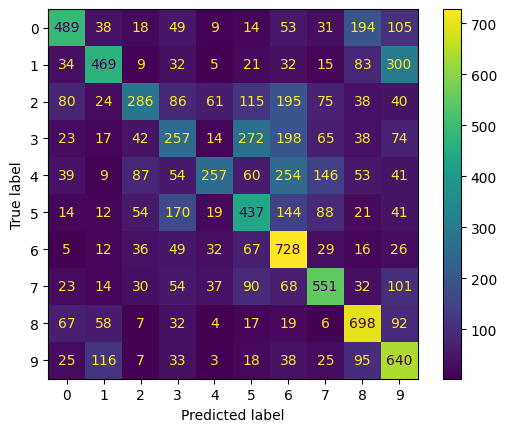

              precision    recall  f1-score   support

           0       0.61      0.49      0.54      1000
           1       0.61      0.47      0.53      1000
           2       0.50      0.29      0.36      1000
           3       0.31      0.26      0.28      1000
           4       0.58      0.26      0.36      1000
           5       0.39      0.44      0.41      1000
           6       0.42      0.73      0.53      1000
           7       0.53      0.55      0.54      1000
           8       0.55      0.70      0.62      1000
           9       0.44      0.64      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.50      0.48      0.47     10000
weighted avg       0.50      0.48      0.47     10000

ROC AUC: 0.8809182555555555
TIME TAKEN: 7407.200815916061 

torch.cuda.total_memory: 7.999512GB
torch.cuda.memory_allocated: 0.998662GB
torch.cuda.memory_reserved: 2.941406GB
torch.cuda.max_memory_reserved: 2.941406GB
================ SEED 1

tensor([[[[243., 273., 271.,  ..., 193., 175., 151.],
          [271., 281., 257.,  ..., 187., 137., 141.],
          [253., 271., 271.,  ..., 195., 151., 133.],
          ...,
          [317., 311., 329.,  ..., 107., 161., 205.],
          [307., 311., 349.,  ...,  63.,  45.,  83.],
          [229., 281., 327.,  ..., 169.,  61., 153.]],

         [[241., 283., 293.,  ..., 199., 181., 155.],
          [277., 291., 273.,  ..., 193., 145., 145.],
          [295., 297., 287.,  ..., 197., 153., 137.],
          ...,
          [321., 303., 307.,  ...,  95., 143., 185.],
          [319., 307., 333.,  ...,  51.,  27.,  67.],
          [237., 277., 309.,  ..., 155.,  53., 153.]],

         [[241., 291., 309.,  ..., 159., 139., 127.],
          [283., 303., 287.,  ..., 147.,  99., 119.],
          [327., 329., 297.,  ..., 153., 109., 113.],
          ...,
          [283., 259., 255.,  ..., 103., 145., 191.],
          [339., 319., 331.,  ...,  57.,  27.,  71.],
          [263., 303., 319.,  ...

[  1/500] Loss: 2.50851 | F1-score: 0.068 | Val Loss: 2.478 | Val F1: 0.089 | 00:02:17s
Validation loss decreased (inf --> 2.477734).  Saving model ...
[  2/500] Loss: 2.30537 | F1-score: 0.130 | Val Loss: 2.176 | Val F1: 0.185 | 00:04:34s
Validation loss decreased (2.477734 --> 2.176372).  Saving model ...
[  3/500] Loss: 2.09200 | F1-score: 0.219 | Val Loss: 2.018 | Val F1: 0.257 | 00:06:55s
Validation loss decreased (2.176372 --> 2.018227).  Saving model ...
[  4/500] Loss: 1.99749 | F1-score: 0.255 | Val Loss: 1.949 | Val F1: 0.289 | 00:09:12s
Validation loss decreased (2.018227 --> 1.948927).  Saving model ...
[  5/500] Loss: 1.95061 | F1-score: 0.278 | Val Loss: 1.906 | Val F1: 0.314 | 00:11:27s
Validation loss decreased (1.948927 --> 1.905858).  Saving model ...
[  6/500] Loss: 1.91219 | F1-score: 0.292 | Val Loss: 1.872 | Val F1: 0.327 | 00:13:46s
Validation loss decreased (1.905858 --> 1.872099).  Saving model ...
[  7/500] Loss: 1.88047 | F1-score: 0.309 | Val Loss: 1.841 | V

C:\Users\hazqe\AAAPython\Anaconda\envs\ai_triage\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[ 10/500] Loss: 1.79899 | F1-score: 0.339 | Val Loss: 1.757 | Val F1: 0.364 | 00:22:49s
Validation loss decreased (1.784455 --> 1.756901).  Saving model ...
[ 11/500] Loss: 1.77877 | F1-score: 0.349 | Val Loss: 1.722 | Val F1: 0.383 | 00:25:04s
Validation loss decreased (1.756901 --> 1.721618).  Saving model ...
[ 12/500] Loss: 1.74906 | F1-score: 0.362 | Val Loss: 1.691 | Val F1: 0.397 | 00:27:21s
Validation loss decreased (1.721618 --> 1.690617).  Saving model ...
[ 13/500] Loss: 1.71713 | F1-score: 0.376 | Val Loss: 1.661 | Val F1: 0.408 | 00:29:38s
Validation loss decreased (1.690617 --> 1.660681).  Saving model ...
[ 14/500] Loss: 1.69690 | F1-score: 0.384 | Val Loss: 1.637 | Val F1: 0.417 | 00:31:54s
Validation loss decreased (1.660681 --> 1.637292).  Saving model ...
[ 15/500] Loss: 1.68117 | F1-score: 0.391 | Val Loss: 1.611 | Val F1: 0.429 | 00:34:09s
Validation loss decreased (1.637292 --> 1.610809).  Saving model ...
[ 16/500] Loss: 1.65896 | F1-score: 0.401 | Val Loss: 1.59

[ 64/500] Loss: 1.29725 | F1-score: 0.531 | Val Loss: 1.247 | Val F1: 0.557 | 02:25:18s
Validation loss decreased (1.254372 --> 1.246546).  Saving model ...
[ 65/500] Loss: 1.29455 | F1-score: 0.535 | Val Loss: 1.247 | Val F1: 0.557 | 02:27:32s
Validation loss decreased (1.246546 --> 1.246512).  Saving model ...
[ 66/500] Loss: 1.28929 | F1-score: 0.536 | Val Loss: 1.241 | Val F1: 0.560 | 02:29:49s
Validation loss decreased (1.246512 --> 1.241279).  Saving model ...
[ 67/500] Loss: 1.28637 | F1-score: 0.537 | Val Loss: 1.242 | Val F1: 0.562 | 02:32:03s
EarlyStopping counter: 1 out of 25
[ 68/500] Loss: 1.28254 | F1-score: 0.538 | Val Loss: 1.239 | Val F1: 0.559 | 02:34:16s
Validation loss decreased (1.241279 --> 1.238686).  Saving model ...
[ 69/500] Loss: 1.28266 | F1-score: 0.537 | Val Loss: 1.235 | Val F1: 0.561 | 02:36:29s
Validation loss decreased (1.238686 --> 1.234740).  Saving model ...
[ 70/500] Loss: 1.27655 | F1-score: 0.540 | Val Loss: 1.230 | Val F1: 0.568 | 02:38:42s
Vali

[122/500] Loss: 1.12887 | F1-score: 0.596 | Val Loss: 1.133 | Val F1: 0.597 | 04:34:04s
EarlyStopping counter: 2 out of 25
[123/500] Loss: 1.12531 | F1-score: 0.596 | Val Loss: 1.125 | Val F1: 0.600 | 04:36:20s
Validation loss decreased (1.129936 --> 1.124837).  Saving model ...
[124/500] Loss: 1.12516 | F1-score: 0.598 | Val Loss: 1.126 | Val F1: 0.601 | 04:38:35s
EarlyStopping counter: 1 out of 25
[125/500] Loss: 1.12199 | F1-score: 0.597 | Val Loss: 1.128 | Val F1: 0.601 | 04:40:52s
EarlyStopping counter: 2 out of 25
[126/500] Loss: 1.12012 | F1-score: 0.601 | Val Loss: 1.123 | Val F1: 0.603 | 04:43:09s
Validation loss decreased (1.124837 --> 1.123498).  Saving model ...
[127/500] Loss: 1.11279 | F1-score: 0.602 | Val Loss: 1.122 | Val F1: 0.604 | 04:45:23s
Validation loss decreased (1.123498 --> 1.122286).  Saving model ...
[128/500] Loss: 1.12094 | F1-score: 0.596 | Val Loss: 1.127 | Val F1: 0.602 | 04:47:37s
EarlyStopping counter: 1 out of 25
[129/500] Loss: 1.11663 | F1-score: 0

[182/500] Loss: 1.01516 | F1-score: 0.638 | Val Loss: 1.079 | Val F1: 0.623 | 06:49:26s
EarlyStopping counter: 1 out of 25
[183/500] Loss: 1.01650 | F1-score: 0.637 | Val Loss: 1.077 | Val F1: 0.622 | 06:51:39s
EarlyStopping counter: 2 out of 25
[184/500] Loss: 1.01494 | F1-score: 0.635 | Val Loss: 1.076 | Val F1: 0.621 | 06:53:52s
EarlyStopping counter: 3 out of 25
[185/500] Loss: 1.01692 | F1-score: 0.639 | Val Loss: 1.075 | Val F1: 0.623 | 06:56:05s
EarlyStopping counter: 4 out of 25
[186/500] Loss: 1.01099 | F1-score: 0.638 | Val Loss: 1.077 | Val F1: 0.619 | 06:58:22s
EarlyStopping counter: 5 out of 25
[187/500] Loss: 1.00599 | F1-score: 0.643 | Val Loss: 1.080 | Val F1: 0.618 | 07:00:42s
EarlyStopping counter: 6 out of 25
[188/500] Loss: 1.00946 | F1-score: 0.641 | Val Loss: 1.073 | Val F1: 0.618 | 07:03:18s
Validation loss decreased (1.073810 --> 1.072576).  Saving model ...
[189/500] Loss: 1.00071 | F1-score: 0.642 | Val Loss: 1.067 | Val F1: 0.623 | 07:05:59s
Validation loss d

[247/500] Loss: 0.93282 | F1-score: 0.667 | Val Loss: 1.052 | Val F1: 0.633 | 09:25:17s
EarlyStopping counter: 3 out of 25
[248/500] Loss: 0.92963 | F1-score: 0.668 | Val Loss: 1.056 | Val F1: 0.632 | 09:27:31s
EarlyStopping counter: 4 out of 25
[249/500] Loss: 0.92668 | F1-score: 0.670 | Val Loss: 1.057 | Val F1: 0.630 | 09:29:46s
EarlyStopping counter: 5 out of 25
[250/500] Loss: 0.93041 | F1-score: 0.668 | Val Loss: 1.054 | Val F1: 0.634 | 09:32:00s
EarlyStopping counter: 6 out of 25
[251/500] Loss: 0.92732 | F1-score: 0.670 | Val Loss: 1.056 | Val F1: 0.627 | 09:34:14s
EarlyStopping counter: 7 out of 25
[252/500] Loss: 0.93159 | F1-score: 0.668 | Val Loss: 1.053 | Val F1: 0.628 | 09:36:29s
EarlyStopping counter: 8 out of 25
[253/500] Loss: 0.92309 | F1-score: 0.671 | Val Loss: 1.057 | Val F1: 0.631 | 09:38:45s
EarlyStopping counter: 9 out of 25
[254/500] Loss: 0.92440 | F1-score: 0.669 | Val Loss: 1.056 | Val F1: 0.628 | 09:41:00s
EarlyStopping counter: 10 out of 25
[255/500] Loss:

[312/500] Loss: 0.87227 | F1-score: 0.688 | Val Loss: 1.032 | Val F1: 0.635 | 11:53:41s
Validation loss decreased (1.036445 --> 1.032373).  Saving model ...
[313/500] Loss: 0.87340 | F1-score: 0.689 | Val Loss: 1.037 | Val F1: 0.639 | 11:55:54s
EarlyStopping counter: 1 out of 25
[314/500] Loss: 0.87940 | F1-score: 0.689 | Val Loss: 1.034 | Val F1: 0.641 | 11:58:10s
EarlyStopping counter: 2 out of 25
[315/500] Loss: 0.87147 | F1-score: 0.691 | Val Loss: 1.037 | Val F1: 0.637 | 12:00:24s
EarlyStopping counter: 3 out of 25
[316/500] Loss: 0.87432 | F1-score: 0.689 | Val Loss: 1.036 | Val F1: 0.640 | 12:02:39s
EarlyStopping counter: 4 out of 25
[317/500] Loss: 0.86960 | F1-score: 0.691 | Val Loss: 1.039 | Val F1: 0.639 | 12:04:52s
EarlyStopping counter: 5 out of 25
[318/500] Loss: 0.86877 | F1-score: 0.692 | Val Loss: 1.038 | Val F1: 0.640 | 12:07:05s
EarlyStopping counter: 6 out of 25
[319/500] Loss: 0.86814 | F1-score: 0.692 | Val Loss: 1.037 | Val F1: 0.638 | 12:09:20s
EarlyStopping cou

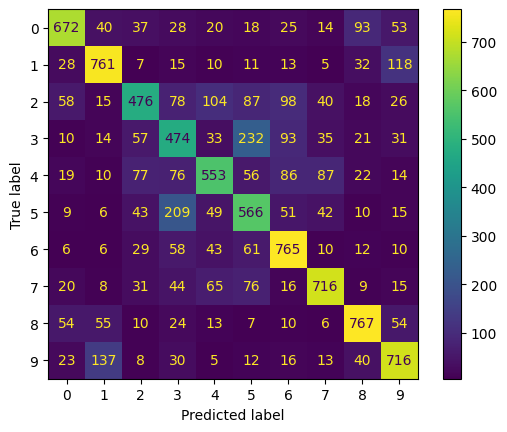

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1000
           1       0.72      0.76      0.74      1000
           2       0.61      0.48      0.54      1000
           3       0.46      0.47      0.47      1000
           4       0.62      0.55      0.58      1000
           5       0.50      0.57      0.53      1000
           6       0.65      0.77      0.70      1000
           7       0.74      0.72      0.73      1000
           8       0.75      0.77      0.76      1000
           9       0.68      0.72      0.70      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

ROC AUC: 0.9365892999999998
TIME TAKEN: 46185.90332365036 

torch.cuda.total_memory: 7.999512GB
torch.cuda.memory_allocated: 0.933537GB
torch.cuda.memory_reserved: 2.625000GB
torch.cuda.max_memory_reserved: 2.941406GB
================ SEED 1

tensor([[[[141., 135., 173.,  ..., 429., 371., 271.],
          [151., 127., 141.,  ..., 301., 263., 243.],
          [157., 135., 133.,  ..., 275., 293., 229.],
          ...,
          [ 77.,  67., 177.,  ..., 327., 319., 305.],
          [123., 111., 175.,  ..., 293., 247., 203.],
          [205., 189., 247.,  ..., 113.,  85.,  87.]],

         [[145., 139., 177.,  ..., 439., 371., 277.],
          [155., 131., 145.,  ..., 313., 265., 241.],
          [163., 139., 137.,  ..., 299., 305., 229.],
          ...,
          [ 79.,  69., 181.,  ..., 335., 329., 315.],
          [133., 119., 179.,  ..., 295., 251., 207.],
          [215., 195., 245.,  ..., 101.,  81.,  91.]],

         [[119., 113., 147.,  ..., 453., 379., 283.],
          [127., 105., 117.,  ..., 333., 277., 241.],
          [127., 109., 109.,  ..., 323., 317., 223.],
          ...,
          [105., 101., 213.,  ..., 367., 363., 357.],
          [169., 157., 213.,  ..., 319., 279., 245.],
          [245., 221., 265.,  ...

[  1/500] Loss: 2.44009 | F1-score: 0.069 | Val Loss: 2.431 | Val F1: 0.094 | 00:02:20s
Validation loss decreased (inf --> 2.430811).  Saving model ...
[  2/500] Loss: 2.33115 | F1-score: 0.113 | Val Loss: 2.249 | Val F1: 0.162 | 00:04:41s
Validation loss decreased (2.430811 --> 2.248790).  Saving model ...
[  3/500] Loss: 2.16585 | F1-score: 0.188 | Val Loss: 2.095 | Val F1: 0.230 | 00:07:03s
Validation loss decreased (2.248790 --> 2.095042).  Saving model ...
[  4/500] Loss: 2.05552 | F1-score: 0.235 | Val Loss: 2.008 | Val F1: 0.263 | 00:09:24s
Validation loss decreased (2.095042 --> 2.008281).  Saving model ...
[  5/500] Loss: 1.99644 | F1-score: 0.257 | Val Loss: 1.958 | Val F1: 0.288 | 00:11:45s
Validation loss decreased (2.008281 --> 1.958347).  Saving model ...
[  6/500] Loss: 1.95672 | F1-score: 0.276 | Val Loss: 1.922 | Val F1: 0.301 | 00:14:07s
Validation loss decreased (1.958347 --> 1.921941).  Saving model ...
[  7/500] Loss: 1.92708 | F1-score: 0.288 | Val Loss: 1.891 | V

C:\Users\hazqe\AAAPython\Anaconda\envs\ai_triage\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[ 10/500] Loss: 1.85640 | F1-score: 0.322 | Val Loss: 1.815 | Val F1: 0.348 | 00:23:36s
Validation loss decreased (1.836361 --> 1.814804).  Saving model ...
[ 11/500] Loss: 1.83729 | F1-score: 0.326 | Val Loss: 1.793 | Val F1: 0.357 | 00:25:57s
Validation loss decreased (1.814804 --> 1.792699).  Saving model ...
[ 12/500] Loss: 1.81608 | F1-score: 0.339 | Val Loss: 1.770 | Val F1: 0.369 | 00:28:18s
Validation loss decreased (1.792699 --> 1.769792).  Saving model ...
[ 13/500] Loss: 1.79786 | F1-score: 0.344 | Val Loss: 1.746 | Val F1: 0.380 | 00:30:35s
Validation loss decreased (1.769792 --> 1.745578).  Saving model ...
[ 14/500] Loss: 1.77941 | F1-score: 0.351 | Val Loss: 1.725 | Val F1: 0.388 | 00:32:57s
Validation loss decreased (1.745578 --> 1.724891).  Saving model ...
[ 15/500] Loss: 1.75935 | F1-score: 0.363 | Val Loss: 1.701 | Val F1: 0.401 | 00:35:18s
Validation loss decreased (1.724891 --> 1.701325).  Saving model ...
[ 16/500] Loss: 1.74204 | F1-score: 0.368 | Val Loss: 1.68

[ 63/500] Loss: 1.40475 | F1-score: 0.494 | Val Loss: 1.341 | Val F1: 0.532 | 02:28:42s
Validation loss decreased (1.340868 --> 1.340793).  Saving model ...
[ 64/500] Loss: 1.40362 | F1-score: 0.498 | Val Loss: 1.337 | Val F1: 0.534 | 02:31:03s
Validation loss decreased (1.340793 --> 1.336866).  Saving model ...
[ 65/500] Loss: 1.39953 | F1-score: 0.502 | Val Loss: 1.335 | Val F1: 0.531 | 02:33:26s
Validation loss decreased (1.336866 --> 1.335327).  Saving model ...
[ 66/500] Loss: 1.39611 | F1-score: 0.500 | Val Loss: 1.329 | Val F1: 0.534 | 02:35:48s
Validation loss decreased (1.335327 --> 1.329245).  Saving model ...
[ 67/500] Loss: 1.39116 | F1-score: 0.499 | Val Loss: 1.326 | Val F1: 0.530 | 02:38:11s
Validation loss decreased (1.329245 --> 1.326285).  Saving model ...
[ 68/500] Loss: 1.39050 | F1-score: 0.500 | Val Loss: 1.325 | Val F1: 0.534 | 02:40:33s
Validation loss decreased (1.326285 --> 1.325093).  Saving model ...
[ 69/500] Loss: 1.38364 | F1-score: 0.503 | Val Loss: 1.32

[119/500] Loss: 1.26718 | F1-score: 0.545 | Val Loss: 1.229 | Val F1: 0.564 | 04:41:46s
Validation loss decreased (1.229668 --> 1.229423).  Saving model ...
[120/500] Loss: 1.27038 | F1-score: 0.546 | Val Loss: 1.231 | Val F1: 0.563 | 04:44:15s
EarlyStopping counter: 1 out of 25
[121/500] Loss: 1.26548 | F1-score: 0.547 | Val Loss: 1.230 | Val F1: 0.563 | 04:46:40s
EarlyStopping counter: 2 out of 25
[122/500] Loss: 1.26224 | F1-score: 0.547 | Val Loss: 1.228 | Val F1: 0.566 | 04:49:02s
Validation loss decreased (1.229423 --> 1.228467).  Saving model ...
[123/500] Loss: 1.26355 | F1-score: 0.551 | Val Loss: 1.223 | Val F1: 0.572 | 04:51:27s
Validation loss decreased (1.228467 --> 1.223213).  Saving model ...
[124/500] Loss: 1.25612 | F1-score: 0.549 | Val Loss: 1.226 | Val F1: 0.566 | 04:53:49s
EarlyStopping counter: 1 out of 25
[125/500] Loss: 1.26329 | F1-score: 0.546 | Val Loss: 1.226 | Val F1: 0.568 | 04:56:10s
EarlyStopping counter: 2 out of 25
[126/500] Loss: 1.25810 | F1-score: 0

[179/500] Loss: 1.18314 | F1-score: 0.577 | Val Loss: 1.178 | Val F1: 0.590 | 07:04:12s
EarlyStopping counter: 1 out of 25
[180/500] Loss: 1.18692 | F1-score: 0.575 | Val Loss: 1.177 | Val F1: 0.588 | 07:06:37s
EarlyStopping counter: 2 out of 25
[181/500] Loss: 1.18221 | F1-score: 0.577 | Val Loss: 1.174 | Val F1: 0.591 | 07:09:00s
Validation loss decreased (1.173773 --> 1.173755).  Saving model ...
[182/500] Loss: 1.18397 | F1-score: 0.578 | Val Loss: 1.174 | Val F1: 0.589 | 07:11:24s
EarlyStopping counter: 1 out of 25
[183/500] Loss: 1.18060 | F1-score: 0.577 | Val Loss: 1.174 | Val F1: 0.589 | 07:13:46s
EarlyStopping counter: 2 out of 25
[184/500] Loss: 1.17905 | F1-score: 0.581 | Val Loss: 1.174 | Val F1: 0.589 | 07:16:08s
EarlyStopping counter: 3 out of 25
[185/500] Loss: 1.17772 | F1-score: 0.578 | Val Loss: 1.172 | Val F1: 0.590 | 07:18:31s
Validation loss decreased (1.173755 --> 1.171704).  Saving model ...
[186/500] Loss: 1.17530 | F1-score: 0.579 | Val Loss: 1.170 | Val F1: 0

[240/500] Loss: 1.12153 | F1-score: 0.600 | Val Loss: 1.142 | Val F1: 0.604 | 09:28:42s
EarlyStopping counter: 4 out of 25
[241/500] Loss: 1.12211 | F1-score: 0.599 | Val Loss: 1.138 | Val F1: 0.603 | 09:31:05s
Validation loss decreased (1.141402 --> 1.137706).  Saving model ...
[242/500] Loss: 1.11662 | F1-score: 0.601 | Val Loss: 1.143 | Val F1: 0.605 | 09:33:27s
EarlyStopping counter: 1 out of 25
[243/500] Loss: 1.12111 | F1-score: 0.599 | Val Loss: 1.142 | Val F1: 0.604 | 09:36:03s
EarlyStopping counter: 2 out of 25
[244/500] Loss: 1.12347 | F1-score: 0.598 | Val Loss: 1.137 | Val F1: 0.604 | 09:38:37s
Validation loss decreased (1.137706 --> 1.136971).  Saving model ...
[245/500] Loss: 1.12524 | F1-score: 0.599 | Val Loss: 1.138 | Val F1: 0.605 | 09:41:13s
EarlyStopping counter: 1 out of 25
[246/500] Loss: 1.12076 | F1-score: 0.600 | Val Loss: 1.137 | Val F1: 0.606 | 09:43:50s
EarlyStopping counter: 2 out of 25
[247/500] Loss: 1.12200 | F1-score: 0.599 | Val Loss: 1.138 | Val F1: 0

In [ ]:
MAX_EPOCHS = 500
result_dict = []
conf_matrix_list = []
train_losses_list = []
valid_losses_list = []

# Assuming you have your features in X and labels in y
skf = StratifiedKFold(n_splits=10, shuffle=True)

curr_split = 1
for train_index, val_index in skf.split(X, y):
    (
        training_data,
        testing_data,
        validating_data,
        test_labels,
        val_labels
    ) = get_splitted_data(train_index, val_index)

    for i in range(len(all_models_list)):
        print(
            f"================ SEED {curr_split} MODEL {i+1}: {all_models_name[i]} ================"
        )
        
        train_loader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE)
        test_loader = DataLoader(dataset=testing_data, batch_size=1)
        val_loader = DataLoader(dataset=validating_data, batch_size=1)
        
        if all_models_name[i] in contain_spect:
            model = all_models_list[i](
                image_size=32, patch_size=16, num_classes=10, dim=512, depth=12, heads=16, mlp_dim=1024,
                channels=3, att_dropout=dropouts_dicts[all_models_name[i]]["att_dropout"],
                ff_dropout=dropouts_dicts[all_models_name[i]]["ff_dropout"],
                drop_path=dropouts_dicts[all_models_name[i]]["drop_path"],
                spect_alpha=contain_spect[all_models_name[i]]["spect_alpha"]
            )
        else:
            model = all_models_list[i](
                image_size=32, patch_size=16, num_classes=10, dim=512, depth=12, heads=16, mlp_dim=1024,
                channels=3, att_dropout=dropouts_dicts[all_models_name[i]]["att_dropout"],
                ff_dropout=dropouts_dicts[all_models_name[i]]["ff_dropout"],
                drop_path=dropouts_dicts[all_models_name[i]]["drop_path"],
            )
        model = model.to(device)


        pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"PARAMETERS: {pytorch_total_params:_}") 
        training_process(model, i, curr_split)
        print("torch.cuda.total_memory: %fGB"%(torch.cuda.get_device_properties(0).total_memory/1024/1024/1024))
        print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
        
        del model
        torch.cuda.empty_cache()

    print("\n\n----------------------------------------------------------")
    print(f"--------------------FINISHED {curr_split}--------------------------")
    print("----------------------------------------------------------\n\n")
    curr_split += 1